In [26]:
import sys
sys.path.append("../")

In [27]:
import matplotlib.pyplot as plt
import numpy as np

from model.dataset import sample_by_quantiles, sample_iid
from model.load import read_csv

from pycox import datasets

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [28]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["cm"],
})

In [29]:
data = datasets.metabric.read_df()
cols_standardise = []
cols_minmax = ['x0', 'x1', 'x2', 'x3','x8']
cols_leave = ['x4','x5','x6','x7']

all_cols = cols_standardise + cols_minmax + cols_leave
standardise = [(f'standard{i}',StandardScaler(), [col]) for i,col in enumerate(cols_standardise)]
leave = [(f'leave{i}','passthrough',[col]) for i,col in enumerate(cols_leave)]
minmax = [(f'minmax{i}',MinMaxScaler(),[col]) for i,col in enumerate(cols_minmax)] 

x_mapper = ColumnTransformer(standardise + minmax + leave) 

features = x_mapper.fit_transform(data).astype('float32')
labels = (data.duration.values, data.event.values)

In [30]:
# datapath = '../Data/data.csv'
# data = read_csv(datapath).sample(frac=0.1)
# print(data.shape)
# data = data.drop(columns='PATIENTID')

# cols_standardise = ['GRADE', 'AGE', 'QUINTILE_2015', 'NORMALISED_HEIGHT', 'NORMALISED_WEIGHT']
# cols_minmax = ['SEX', 'TUMOUR_COUNT', 'REGIMEN_COUNT']
# cols_leave = ['SACT', 'CLINICAL_TRIAL_INDICATOR', 'CHEMO_RADIATION_INDICATOR','BENIGN_BEHAVIOUR','SITE_C70', 'SITE_C71', 'SITE_C72', 'SITE_D32','SITE_D33','SITE_D35','CREG_L0201','CREG_L0301','CREG_L0401','CREG_L0801','CREG_L0901','CREG_L1001','CREG_L1201','CREG_L1701','LAT_9','LAT_B','LAT_L','LAT_M','LAT_R','ETH_A','ETH_B','ETH_C','ETH_M','ETH_O','ETH_U','ETH_W','DAYS_TO_FIRST_SURGERY']

# all_cols = cols_standardise + cols_minmax + cols_leave

# print(len(data.columns) == len(cols_standardise + cols_minmax + cols_leave) + 2)

# standardise = [([col], StandardScaler()) for col in cols_standardise]
# minmax = [([col], MinMaxScaler()) for col in cols_minmax]
# leave = [(col, None) for col in cols_leave]

# x_mapper = DataFrameMapper(standardise + minmax + leave)

# features = x_mapper.fit_transform(data).astype('float32')
# labels = (data.DAYS_SINCE_DIAGNOSIS.values, data.EVENT.values)

In [31]:
dict_center_idxs = sample_iid(features, 4)
# dict_center_idxs = sample_by_quantiles(labels, 0, 4)

In [32]:
def rand_jitter(applyto, arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

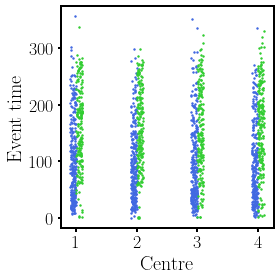

In [33]:
categories = list('1234')
fig, ax = plt.subplots(figsize=(4,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
colors = ["royalblue",'limegreen']
dotsize = 2
marker = 'o'
smallfont = 18
bigfont = 20
for center, idxs in enumerate(dict_center_idxs.values()):
    durations = labels[0][list(idxs)]
    events = labels[1][list(idxs)]

    uncensored = durations[np.where(events == 1)]
    censored = durations[np.where(events == 0)]

    width = 0.1
    x = np.ones(len(uncensored)) * center - width/2 + (np.random.rand(len(uncensored))*width-width/2.)
    if center == 0:
        ax.scatter(x, uncensored, marker=marker,s=dotsize, color=colors[0], label='Uncensored')
    else:
        ax.scatter(x, uncensored, marker=marker,s=dotsize, color=colors[0])
    x = np.ones(len(censored)) * center + width/2 + (np.random.rand(len(censored))*width-width/2.)
    if center == 0:
        ax.scatter(x, censored, marker=marker,s=dotsize, color=colors[1], label='Censored')
    else:
        ax.scatter(x, censored, marker=marker,s=dotsize, color=colors[1])
    # ax.legend(fontsize=smallfont, markerscale=5)

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, fontsize=smallfont)
ax.tick_params(axis='y', labelsize=smallfont)
# ax.set_yticklabels([0,500,1000,1500,2000,2500,3000], fontsize=14)
ax.set_xlabel('Centre', fontsize=bigfont)
ax.set_ylabel('Event time', fontsize=bigfont)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
plt.tight_layout()
plt.savefig('../figs/iid.png', format='png')
